In [ ]:
from __future__ import division

import skimage.data

import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import random
import cv2

In [2]:


def _generate_segments(im_orig, scale, sigma, min_size):
    """
        segment smallest regions by the algorithm of Felzenswalb and
        Huttenlocher
    """

    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)
      
        
    # merge mask channel to the image as a 4th channel
    im_orig = numpy.append(
        im_orig, numpy.zeros(im_orig.shape[:2])[:, :, numpy.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask

    return im_orig, im_mask



In [3]:


def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])



In [4]:


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])



In [5]:


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize



In [6]:


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize



In [7]:


def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))



In [8]:


def _calc_colour_hist(img):
    """
        calculate colour histogram for each region
        the size of output histogram will be BINS * COLOUR_CHANNELS(3)
        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]
        extract HSV
    """

    BINS = 25
    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist



In [9]:


def _calc_texture_gradient(img):
    """
        calculate texture gradient for entire image
        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.
        output will be [height(*)][width(*)]
    """
    ret = numpy.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret



In [10]:


def _calc_texture_hist(img):
    """
        calculate texture histogram for each region
        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist



In [11]:


def _extract_regions(img):

    R = {}

    # get hsv image
    hsv = skimage.color.rgb2hsv(img[:, :, :3])

    # pass 1: count pixel positions
    for y, i in enumerate(img):

        for x, (r, g, b, l) in enumerate(i):

            # initialize a new region
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img)

    # pass 3: calculate colour histogram of each region
    for k, v in list(R.items()):

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        #masked_pixels = img[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

        # texture histogram
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R



In [12]:


def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours



In [13]:


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt



In [14]:


# randomly creates RGB
def random_rgb():
    rgb = numpy.zeros(3, dtype=int)
    rgb[0] = random.randint(0, 255)
    rgb[1] = random.randint(0, 255)
    rgb[2] = random.randint(0, 255)
    return rgb



In [15]:


def show_result(img, regions):
    
    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 500 pixels
        #if r['size'] < 500:
        #    continue
        # distorted rects
        x, y, w, h = r['rect']
        #if w / h > 1.2 or h / w > 1.2:
        #    continue
        candidates.add(r['rect'])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
    ax.imshow(img)
    print('num of candidate: ',len(candidates))
    for x, y, w, h in candidates:
        #print(x, y, w, h)
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    #plt.show()



In [16]:


class Show_Result:
    
    def __init__(self,img, ncols, nrows):
        self.img = img
        self.fig, self.ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=(24,10))
        self.ncols = ncols
        self.nrows = nrows
        self.ccols = 0
        self.crows = 0
    
    def setTitle(self, title):
        self.fig.suptitle(title, fontsize=30)
        
    def addSegmentResult(self, im_mask):
        nlabel = len(numpy.unique(im_mask))
        colors=numpy.random.random((nlabel, 3))
        self.ax[self.crows][self.ccols].set_title('Result of Felzenszwalb algorithm')
        self.ax[self.crows][self.ccols].imshow(skimage.color.label2rgb(label=im_mask, image=self.img, colors=numpy.random.random((nlabel, 3))))
        self.ccols = self.ccols + 1
    
    def addResult(self, regions, title):
        candidates = set()
        for r in regions:
            # excluding same rectangle (with different segments)
            if r['rect'] in candidates:
                continue
            # excluding regions smaller than 500 pixels
            #if r['size'] < 500:
            #    continue
            # distorted rects
            x, y, w, h = r['rect']
            #if w / h > 1.2 or h / w > 1.2:
            #    continue
            candidates.add(r['rect'])
            
        self.ax[self.crows][self.ccols].imshow(self.img)
            
        for x, y, w, h in candidates:
            #print(x, y, w, h)
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
            self.ax[self.crows][self.ccols].add_patch(rect)
        self.ax[self.crows][self.ccols].set_title(title, fontsize=20)
        
        if self.ccols+1 == self.ncols:
            self.crows = self.crows + 1
            self.ccols = 0
        else:
            self.ccols = self.ccols + 1
    """
    def addResult(self, regions):
        candidates = set()
        for r in regions:
            # excluding same rectangle (with different segments)
            if r['rect'] in candidates:
                continue
            # excluding regions smaller than 500 pixels
            #if r['size'] < 500:
            #    continue
            # distorted rects
            x, y, w, h = r['rect']
            #if w / h > 1.2 or h / w > 1.2:
            #    continue
            candidates.add(r['rect'])
            
        self.ax[self.crows][self.ccols].imshow(self.img)
            
        for x, y, w, h in candidates:
            #print(x, y, w, h)
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
            self.ax[self.crows][self.ccols].add_patch(rect)
        self.ax[self.crows][self.ccols].set_title('test', fontsize=20)
        
        if self.ccols+1 == self.ncols:
            self.crows = self.crows + 1
            self.ccols = 0
        else:
            self.ccols = self.ccols + 1
    
    """
    def showResult(self):
        plt.show()
        



In [17]:


def get_regions(R):
    regions = []
    for k, r in list(R.items()):
        
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })
    
    return regions



In [18]:


def canAddResult(comp_len_S, current_len_S):
    if current_len_S < comp_len_S/2:
        return True
    else:
        return False



In [19]:


def get_all_regions(R):
    regions = []
    
    for _R in R:
        for m, r in list(_R.items()):
            regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })
    
    return regions



In [20]:


def selective_search(im_orig, scale=1.0, sigma=0.8, min_size=50):
    '''Selective Search
    Parameters
    ----------
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.
    Returns
    -------
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                },
                ...
            ]
    '''
    assert im_orig.shape[2] == 3, "3ch image is expected"
    cv2.
    
    print('[Start SS] scale = ',scale,' sigma = ',sigma,' min_size = ',min_size)
    
    # 결과 확인을 위한 부분
    showResult = Show_Result(im_orig,3,2)
    showResult.setTitle('scale = '+str(scale)+', sigma = '+str(sigma)+', min_size = '+str(min_size))
    
    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img, im_mask = _generate_segments(im_orig, scale, sigma, min_size)
    
    # Graph based segmentation 결과 확인
    showResult.addSegmentResult(im_mask)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    R = []
    R.append(_extract_regions(img))
    

    # extract neighbouring information
    neighbours = _extract_neighbours(R[0])

    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize)
    
    # 초기 region 결과 확인
    current_regions = get_regions(R[0])
    showResult.addResult(current_regions,'# of regions: ' + str(len(current_regions)))
    
    # 결과 확인을 위한 변수
    comp_len_S = len(S)
    count = 0
    flag = True

    # hierarchal search
    
    index = 0
    
    while S != {}:
        
        R.append(copy.deepcopy(R[index]))
        index = index + 1
        
        # get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # merge corresponding regions
        t = max(R[index].keys()) + 1.0
        R[index][t] = _merge_regions(R[index][i], R[index][j])
        del R[index][i]
        del R[index][j]
        
        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[index][t], R[index][n], imsize)
        
        # 결과 확인을 위한 부분
        if count < 2 and canAddResult(comp_len_S, len(S)):
            comp_len_S = len(S)
            current_regions = get_regions(R[index])
            showResult.addResult(current_regions, '# of regions: ' + str(len(current_regions)))
            count = count + 1
            
        if flag and 5 < len(S) <15:
            current_regions = get_regions(R[index])
            result.addResult(current_regions,'# of r: ' + str(len(current_regions)) + ' ('+str(scale)+', '+str(sigma)+', '+str(min_size)+')')
            #result.addResult(get_regions(R[index]))
            flag = False
            
        
    # 결과 확인을 위한 부분
    regions = get_regions(R[len(R)-1])
    showResult.addResult(regions,'# of regions: ' + str(len(regions)))
    regions = get_all_regions(R)
    showResult.addResult(get_all_regions(R), 'All Regions: '+str(R))
    
    print('[Done]')
    
    return
    #return img, regions



In [21]:


#img = skimage.data.astronaut()

IMG_PATH = './sampleImg/test.jpg'
img = numpy.array(Image.open(IMG_PATH))
img.shape

sample = cv2.imread(IMG_PATH)
plt.imshow(sample)
plt.show()


(455, 700, 3)

[Start SS] scale =  30  sigma =  0.9  min_size =  100
[Done]


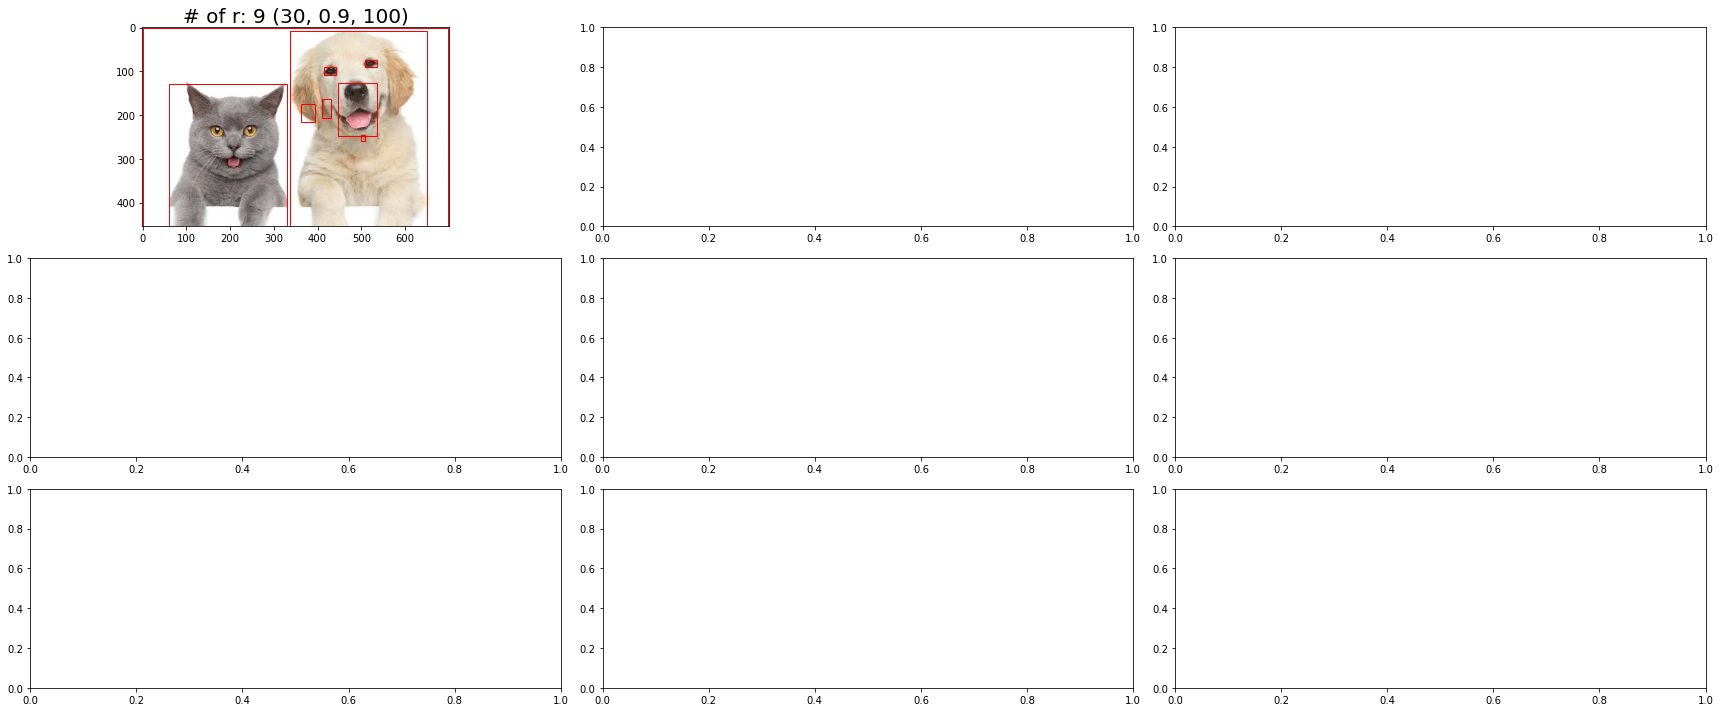

In [ ]:


global result
result = Show_Result(img, 3,3)


# scale을 조절할 경우
#scale : int
#    Free parameter. Higher means larger clusters in felzenszwalb segmentation.
#print('-------------scale을 조절할 경우------------------')
#selective_search(img, scale=1, sigma=0.9, min_size=50)
#selective_search(img, scale=30, sigma=0.9, min_size=50)
#selective_search(img, scale=100, sigma=0.9, min_size=50)
#print('------------------------------------------------')
# sigma를 조절할 경우
#sigma : float
#   Width of Gaussian kernel for felzenszwalb segmentation.
#print('\n\n\n-------------sigma를 조절할 경우------------------')
#selective_search(img, scale=30, sigma=0.3, min_size=50)
#selective_search(img, scale=30, sigma=0.6, min_size=50)
#selective_search(img, scale=30, sigma=1.0, min_size=50)
#print('------------------------------------------------')

# min_size를 조절할 경우
#min_size : int
#            Minimum component size for felzenszwalb segmentation.
#print('\n\n\n-------------min_size를 조절할 경우------------------')
#selective_search(img, scale=30, sigma=0.9, min_size=10)
#selective_search(img, scale=30, sigma=0.9, min_size=100)
#selective_search(img, scale=30, sigma=0.9, min_size=300)

result.fig.tight_layout()

plt.show()